In [ ]:
!pip install corner
!pip install emcee
import os
import h5py
import corner
import emcee
import numpy as np
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt
from scipy.integrate import odeint
#from scipy.optimize import minimize
from IPython.display import display, Math


from google.colab import files
os.environ["OMP_NUM_THREADS"] = "2"

     |████████████████████████████████| 51kB 2.8MB/s 


In [ ]:
df = pd.read_excel('Base de datos Dengue.xlsx',"Casos")

Saving Dengue_nominal 3.xlsx to Dengue_nominal 3.xlsx


In [ ]:
#--------------------------
#Load Data

df = pd.read_excel('Base de datos Dengue.xlsx',"Casos")
Datos = df["DENGUE"]+df["DENGUE GRAVE"]
humanos=Datos.values[:20]
#--------------------------
# Ross-Mcdonald paramters and initial conditions



ai,deltai,xii,bi,ci,Hi,Vi,m0=0.9, 0.55, 3/5, 0.2, 0.6, 6407000, 9091886, 500

pos = np.array([ai,deltai,xii,bi,ci,Vi,m0]) + 1e-3 * np.random.randn(32, 7)#initial vector 
nwalkers, ndim = pos.shape
#--------------------------
# elapsed time of study 

t = np.arange(0,len(humanos))
#--------------------------
# steps 

nsteps=100000
#--------------------------
# save file name 

filename = "Intento.h5"

In [ ]:
def RM(X, t, a, delta, xi, b, c, H, V):
    """The Ross-Mcdonald equations."""
    h, m  = X
    hp = a*b*m*(H - h)/H - xi*h
    mp = a*c*h*(V - m)/H - delta*m
    return hp, mp

def log_likelihood(theta, t, humanos):
    a, delta, xi, b, c, V, m0 = theta 
    f = odeint(RM, (humanos[0], m0), t, args=(a, delta, xi, b, c, Hi, V))
    h, m = f.T
    return -(1/2)*(1/len(humanos))*np.sum((humanos-h)**2)

def log_probability(theta, t, humanos):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, humanos)

def plotSteps(samples,ndim,save=False,name="steps prior 16.png"):
    fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True)
    labels = [r"$a$", r"$\delta$", r"$\xi$", "b","c","V","$m_0$"]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("Step number");
    if(save):
        plt.savefig(name,bbox_inches='tight', dpi=180)


In [ ]:
def log_prior(theta):#Primer intento
    a, delta, xi, b, c, V, m0 = theta 
    if 0 < a < 1 and 1/2 <= delta <= 7 and 7/12 < xi < 7/4 and 0.1 < b < 0.75 and 0.4 < c < 1 and 0<V<1200000000 and 0<m0<100000:
        return 0.0
    return -np.inf


In [ ]:
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

In [ ]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t,humanos), pool=pool,backend=backend)
    sampler.run_mcmc(pos,  nsteps, progress=True);
    sampler.get_blobs(discard=1000)

100%|██████████| 100000/100000 [53:41<00:00, 31.04it/s]


In [ ]:
n=50

flat_samples = sampler.get_chain(flat=True)

a, delta, xi = np.percentile(flat_samples[:, 0], [n])[0],np.percentile(flat_samples[:, 1], [n])[0], np.percentile(flat_samples[:, 2], [n])[0]
b, c = np.percentile(flat_samples[:, 3], [n])[0],np.percentile(flat_samples[:, 4], [n])[0]
#H=np.percentile(flat_samples[:, 5], [n])[0]
V=np.percentile(flat_samples[:, 5], [n])[0]
m0=np.percentile(flat_samples[:, 6], [n])[0]

In [ ]:
print("Mosquito biting rate "+"a"+" = ",a," -> Mosquito bites one out of ",a*10, "people") 
print("Mosquito death rate "+r"$delta$"+" = ",delta, " -> Average duration of mosquito infection ",7/(delta), "days")
print("Human recovery rate "+r"xi"+" = ",xi, " -> Average duration of human infection ",7/xi, "days")
print(" ")
print("Mosquito to human transmission probability "+"$b$"+" = ",b,"  -> The",(b)*100," out of this bites infect healthy people")
print("Human to mosquito transmission probability "+"$c$"+" = ",c,"  -> The",(c)*100," out of this bites infect susceptible mosquitos")
print(" ")
print("Humans = ",Hi)
print("Mosquitos = ",V)
print("-> There are",(V)/Hi, "more mosquitos than people")
print(" ")
print("m0 = ",m0)

Mosquito biting rate a =  0.865202532636575  -> Mosquito bites one out of  8.65202532636575 people
Mosquito death rate $delta$ =  0.504959147900467  -> Average duration of mosquito infection  13.862507549580577 days
Human recovery rate xi =  0.5874042976425974  -> Average duration of human infection  11.916834841169493 days
 
Mosquito to human transmission probability $b$ =  0.38193778094634595   -> The 38.193778094634595  out of this bites infect healthy people
Human to mosquito transmission probability $c$ =  0.8443833727153354   -> The 84.43833727153354  out of this bites infect susceptible mosquitos
 
Humans =  6407000
Mosquitos =  9192990.541451622
-> There are 1.43483542086025 more mosquitos than people
 
m0 =  521.5106743955242


In [ ]:
labels = [r"$a$", r"$\delta$", r"$\xi$", "b","c","V","$m_0$"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

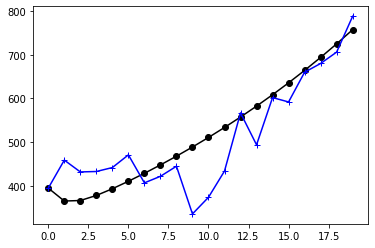

In [ ]:
f = odeint(RM, (humanos[0],m0), t, args=(a, delta, xi, b, c, Hi, V))
h,m = f.T
plt.plot(t,h,"ko-") # El resultado mean
plt.plot(t,humanos,"b+-") # Datos reales

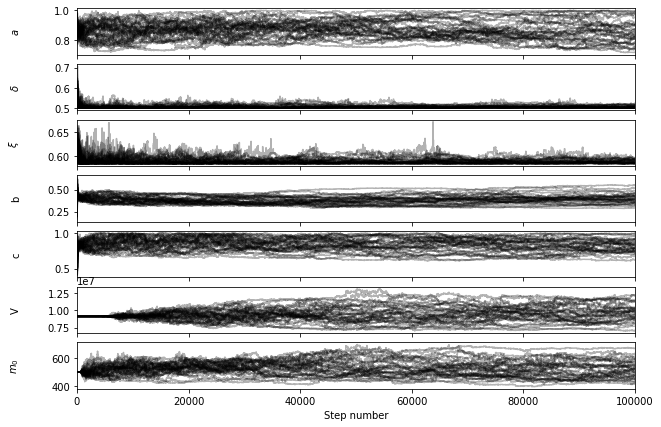

In [ ]:
samples = sampler.get_chain()
plotSteps(samples,ndim,True,"Steps_AntioquiaPriorSinAcotar.png")

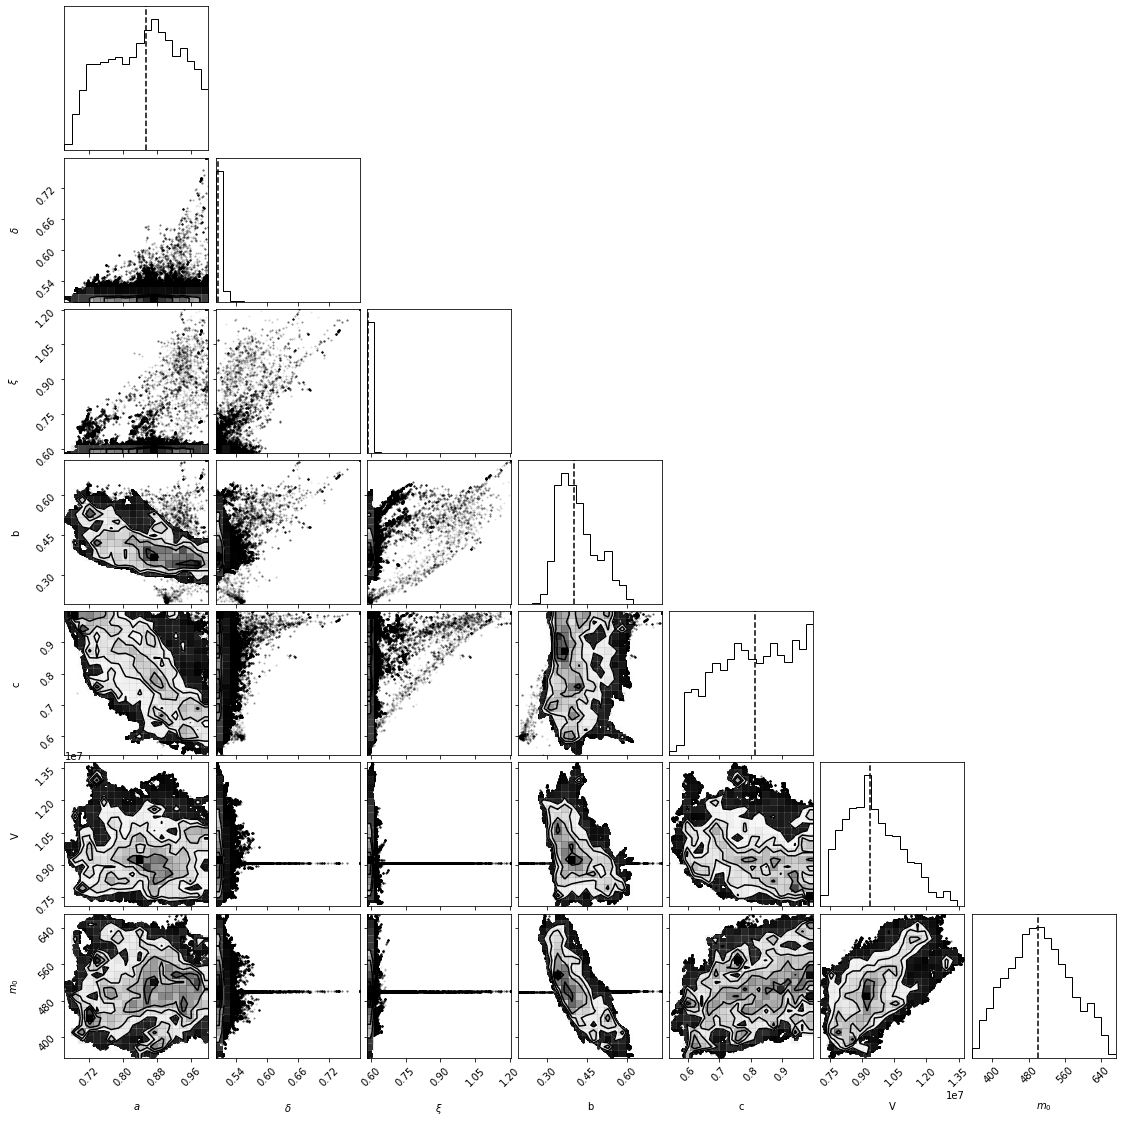

In [ ]:
labels = [r"$a$", r"$\delta$", r"$\xi$", "b","c","V","$m_0$"]
flat_samples = sampler.get_chain(flat=True)
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.5]);
plt.savefig("Histograma_AntioquiaPriorSinAcotar.png",bbox_inches='tight', dpi=180)